# Imports

https://blog.devgenius.io/spotify-data-analysis-with-python-a727542beaa7

In [10]:
# load all json files in /data folder
# create a dataframe with all the data
# save the dataframe as a csv file
import json
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import pickle
from collections import defaultdict
from scipy.optimize import curve_fit

# Getting data

In [11]:
G = pickle.load(open('directed_Multi_twitter_graph.pickle', 'rb'))
print(G)

def convert_to_digraph(Mgraph):
    DiG = nx.DiGraph()
    edge_dict = defaultdict(lambda: {'year': [], 'ID': [],'weight':0})

    for u,v,data in Mgraph.edges(data=True):
        edge_data = edge_dict[(u,v)]

        edge_data['year'].append(data['year'])
        edge_data['ID'].append(data['ID'])

        # update weights
        edge_data['weight'] = len(edge_data['year'])

    # add edge data
    for key, value in edge_dict.items():
        DiG.add_edge(*key, **value) # DiGraph with 803 nodes and 142530 edges

    nx.set_node_attributes(DiG,Mgraph.nodes)

    # add nodes data
    ##for node, data in Mgraph.nodes.items():
     #   DiG.set

    return DiG

#DiG = convert_to_digraph(G)

##print(DiG)
##print(next(iter(DiG.edges(data=True))))
#G = DiG

MultiDiGraph with 803 nodes and 1602970 edges


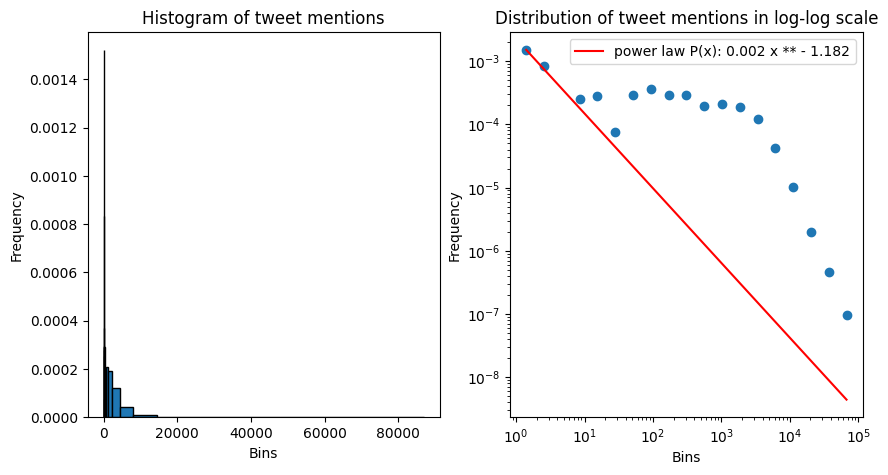

In [3]:
def power_law_plots(data, name):
    '''
    data: the data to use
    name: the name of the variable in interest
    '''
    # Define the bin edges using a logarithmic scale
    logbins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), 20)

    # Create the histogram
    hist, bins = np.histogram(data, bins=logbins, density=True)

    # Compute the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    def power_law(x, C, gamma):
        return C * x**(-gamma)

    popt, pcov = curve_fit(power_law, bin_centers, hist, maxfev=10000)

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the histogram on the first subplot
    ax[0].bar(bins[:-1], hist, width=np.diff(bins), align='edge', edgecolor='black')
    ax[0].set_xlabel('Bins')
    ax[0].set_ylabel('Frequency')
    ax[1].set_yscale('log')
    ax[0].set_title(f'Histogram of {name}')

    # Plot the line on the second subplot
    ax[1].scatter(bin_centers, hist)
    ax[1].plot(bin_centers, power_law(bin_centers, *popt), 'r-', label='power law P(x): %5.3f x ** - %5.3f' % tuple(popt))
    ax[1].set_xlabel('Bins')
    ax[1].set_ylabel('Frequency')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_title(f'Distribution of {name} in log-log scale')
    #ax[1].set_xlim(left=00000.000000001,right=max(bin_centers))
    #ax[1].set_ylim(bottom=00000.000000001,top=max(power_law(bin_centers, *popt)))
    ax[1].legend()

    plt.show()

power_law_plots([mentions for node, mentions in G.degree(weight='weight')], 'tweet mentions')

# Part 1: Mixing Patterns and Assortativity

We want to start by investigate the network structure of the U.S congress. Specifically, we want to investigate the relationship between the different parties. As a starting, we compute the fraction of edges from a member that is toward a member of the same party. We then 100 times shuffle the members party affiliation and plot the distribuition as a histogram together with the actual fraction from the data. 

In [12]:
# filter based on dem and rep
selected_nodes = [n for n,v in G.nodes(data=True) if v['party'] == 'D' or v['party'] == 'R' or v['party'] == 'I' ]  
G = G.subgraph(selected_nodes)


In [13]:

# gets the top field of each node
node_fiels_dict = nx.get_node_attributes(G,'party')


# goes over all nodes and its neighbor's calculates the fractions of neighbors in the same field
def neighbor_same_field_frac(G, node_fiels_dict):
    node_adj_same_field_frac_list = []

    # loops over all nodes
    for node_id in G.nodes:
        # gets their top field
        node_field = node_fiels_dict.get(node_id)
         
        # gets neighbors top field
        neighbor_fields = [node_fiels_dict.get(key) for key in G.neighbors(node_id)]
        
        # Creates list of true and false if they are in same field
        same_field_list = [1 if node_field == neighbor_field else 0 for neighbor_field in neighbor_fields]

        # adds fraction if node has edges
        if len(same_field_list) != 0:
            node_adj_same_field_frac_list.append(sum(same_field_list)/len(same_field_list))
        
    
    # returns mean over all nodes
    return np.mean(node_adj_same_field_frac_list)

node_adj_same_field_frac = neighbor_same_field_frac(G, node_fiels_dict)
print(f"node_adj_same_field_frac_list: {node_adj_same_field_frac}")

node_adj_same_field_frac_list: 0.7218477082897623


In [14]:
def shuffle_node_fiels_dict(node_fiels_dict):
    """ Function that shuffles top fields in a dictionary
    """
    # gets all top fields
    top_fields = list(node_fiels_dict.values())

    # shuffles top_fields
    shuffled_top_field = random.sample(top_fields, len(node_fiels_dict))

    # create new dict
    node_fiels_dict = dict(zip(list(node_fiels_dict.keys()), shuffled_top_field))

    return node_fiels_dict

# number of samples
n = 200

# we shuffle the top_field and calculate the fraction 200 times
neighbor_same_field_frac_shuffled_list = []
for i in range(n):
    node_fiels_dict = shuffle_node_fiels_dict(node_fiels_dict)
    neighbor_same_field_frac_shuffled_list.append(neighbor_same_field_frac(G, node_fiels_dict))

0.0
Reject the null hypothesis with p value:  0.0


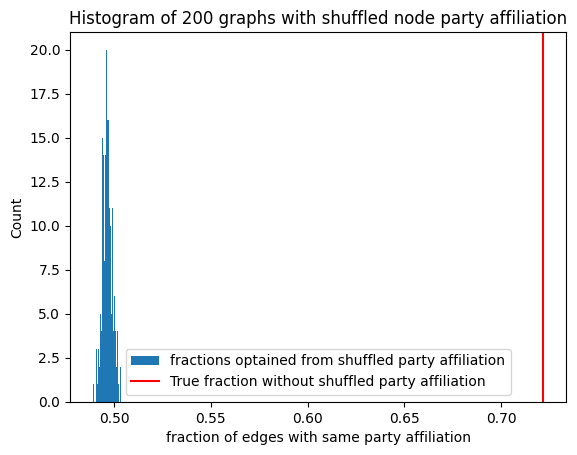

In [15]:
# Creates the histogram plot
fig, ax = plt.subplots()
ax.hist(neighbor_same_field_frac_shuffled_list, label='fractions optained from shuffled party affiliation', bins=30)
ax.axvline(x=node_adj_same_field_frac,color='r',linestyle='-', label='True fraction without shuffled party affiliation')
ax.set_title('Histogram of 200 graphs with shuffled node party affiliation')
ax.legend()
ax.set_xlabel('fraction of edges with same party affiliation')
ax.set_ylabel('Count')

# We then perform a permutation test using the data genereated in the above cell
t_obs = node_adj_same_field_frac
tq = np.mean(neighbor_same_field_frac_shuffled_list > node_adj_same_field_frac)

# calculate p value
p_value = tq
print(p_value)

# Compare the p-value to the significance level (e.g., 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis with p value: ", p_value)
else:
    print("Fail to reject the null hypothesis with p value: ", p_value)

From this we can observe that that we get a p value of under 0.05 which means that the fraction of edges from a member that is toward a member of the same party is significantly higher than what we would expect if the party affiliation was randomly distributed. This supports the belive that members of the U.S congress are more likely to messsage eachother internally in each party.

To further investiage this, we compute the assortativity coefficient with respect to party of the nodes of Republicans, Democrats, and Independents. The count of edges can be seen in the confusion metrix below. This results in an assortativity coefficient of 0.65. This tells is that there is an high assortivity. It is important to mention that this only counts mentions in each tweet not how the mention is. Is it communication, a pr post, or just…..

In [16]:
next(iter(G.edges))

('Lois Frankel', 'Senate Republicans', 0)

assortativity coefficient with respect to author's field:  0.6482423124188517


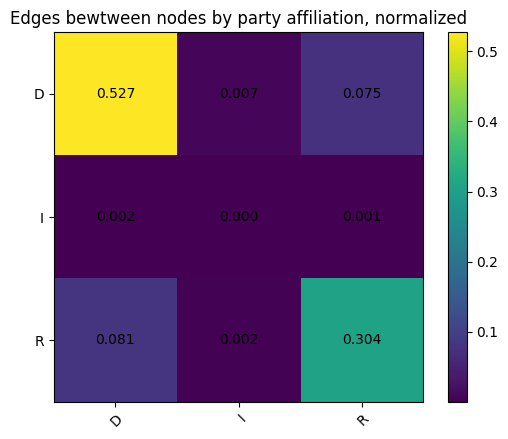

In [18]:
# extracts all unique 'top_field' values from the network G and stores them in a list called 'uniqe_top_fields
uniqe_top_fields = list(np.unique(list(node_fiels_dict.values())))
node_fiels_dict = nx.get_node_attributes(G,'party')

# creates a dictionary that maps each 'top_field' value to an index in the adjacency matrix 'e'.
uniqe_top_fields_mapping = {uniqe_top_fields[i]: i for i in range(len(uniqe_top_fields)) }
e = np.zeros((len(uniqe_top_fields),len(uniqe_top_fields)))

# Calcultes the matrix e from equation 2 in the recommended paper.
for node1, node2,weight in G.edges: # 
    node1_field = node_fiels_dict.get(node1)
    node1_field_index = uniqe_top_fields_mapping.get(node1_field)
    node2_field = node_fiels_dict.get(node2)
    node2_field_index = uniqe_top_fields_mapping.get(node2_field)

    # adds 1 to the total number of edges between these two fields
    e[node1_field_index, node2_field_index] += 1
    #e[node2_field_index, node1_field_index] += 1

e /= (len(G.edges))

# computes the assortativity coefficient
ass_coef = (np.trace(e) - np.sum(np.matmul(e,e))) / (1-np.sum(np.matmul(e,e)))
print("assortativity coefficient with respect to author's field: ", ass_coef)

# creates a plot to show the matrix e
fig, ax = plt.subplots()
im = ax.imshow(e)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(uniqe_top_fields)), labels=uniqe_top_fields)
ax.set_yticks(np.arange(len(uniqe_top_fields)), labels=uniqe_top_fields)
plt.title('Edges bewtween nodes by party affiliation, normalized')
ax.figure.colorbar(im, ax=ax)

# Loop through each cell in the confusion matrix and add the cell value as text label
for i in range(len(uniqe_top_fields)):
    for j in range(len(uniqe_top_fields)):
        text = ax.text(j, i, f"{e[i, j]:.3f}",
                       ha="center", va="center", color="k")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()

directed graph?? use directed modularity.

temporal data pr year?

# Diffrent years

(0.0, 0.40593853261866025)

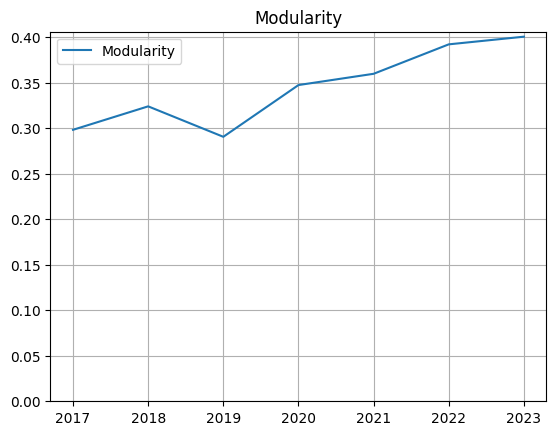

In [19]:
with open('/work/sorted_louvain_communities.pickle', 'rb') as handle:
    partition_GM = pickle.load(handle)

assortivity_list = []

for year in ['2017','2018','2019','2020','2021','2022','2023']:
    G = pickle.load(open(f'/work/directed_multi_twitter_graph_fixed{year}.pickle', 'rb'))
    subgraph_nodes = list(G.nodes())
    
    subgraph_partision = [list(set(group_list).intersection(subgraph_nodes)) for group_list in partition_GM]
    
    assortivity_list.append(nx.community.modularity(G,subgraph_partision))


plt.plot([2017,2018,2019,2020,2021,2022,2023], assortivity_list, label='Modularity')
plt.legend()
plt.grid()
plt.title('Modularity')
plt.ylim(bottom=0)

assortativity coefficient with respect to party affiliation in year 2017:  0.4454388227132529


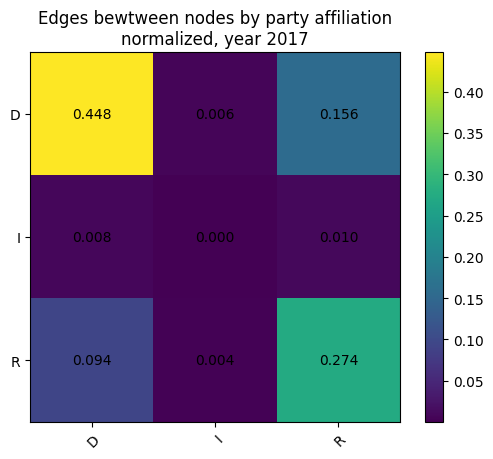

assortativity coefficient with respect to party affiliation in year 2018:  0.46103344088131115


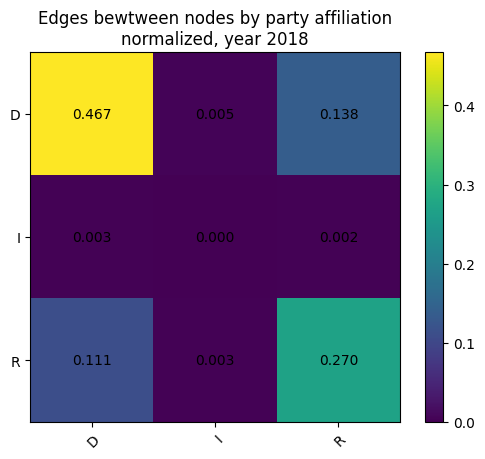

assortativity coefficient with respect to party affiliation in year 2019:  0.4498299602973486


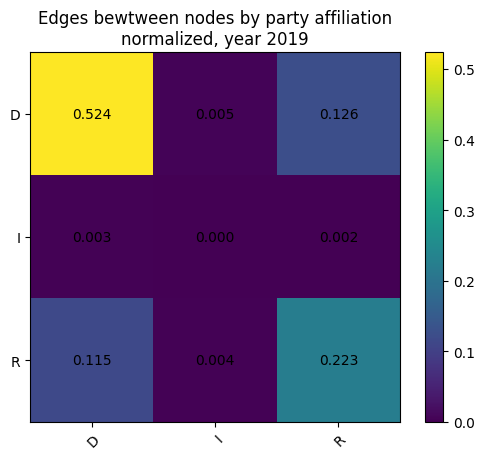

assortativity coefficient with respect to party affiliation in year 2020:  0.508209882699631


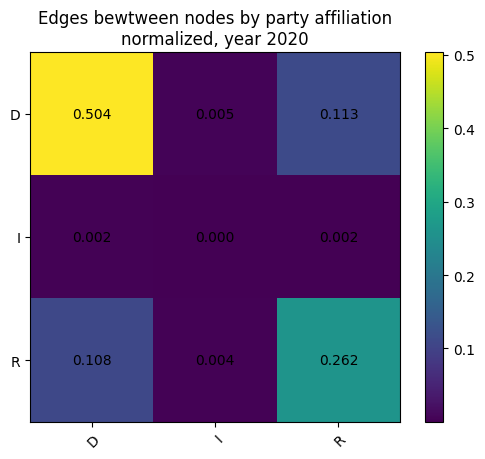

assortativity coefficient with respect to party affiliation in year 2021:  0.5781091976200021


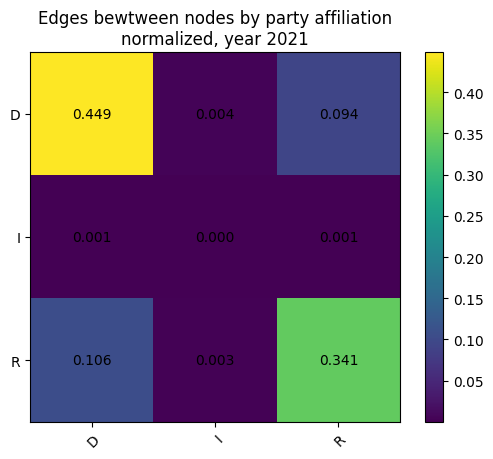

assortativity coefficient with respect to party affiliation in year 2022:  0.6149489069532748


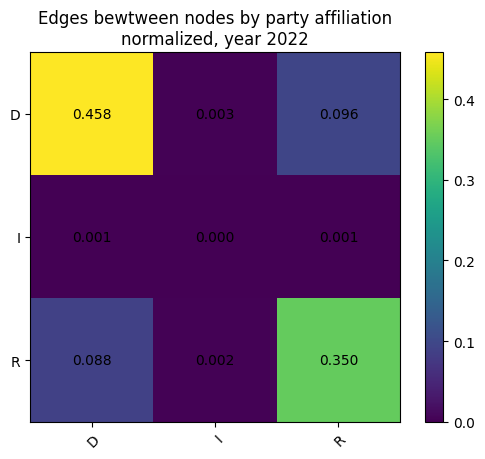

assortativity coefficient with respect to party affiliation in year 2023:  0.6222202409917523


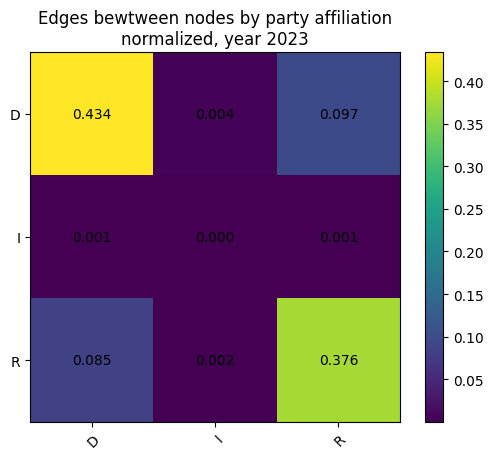

In [21]:
normalized_list = []
ass_coef_list = []


for year in ['2017','2018','2019','2020','2021','2022','2023']:
    G = pickle.load(open(f'/work/directed_multi_twitter_graph_fixed{year}.pickle', 'rb'))
    G = convert_to_digraph(G)

    selected_nodes = [n for n,v in G.nodes(data=True) if v['party'] == 'D' or v['party'] == 'R' or v['party'] == 'I' ]  
    G = G.subgraph(selected_nodes)

    # extracts all unique 'top_field' values from the network G and stores them in a list called 'uniqe_top_fields
    uniqe_top_fields = list(np.unique(list(node_fiels_dict.values())))
    node_fiels_dict = nx.get_node_attributes(G,'party')

    # creates a dictionary that maps each 'top_field' value to an index in the adjacency matrix 'e'.
    uniqe_top_fields_mapping = {uniqe_top_fields[i]: i for i in range(len(uniqe_top_fields)) }
    e = np.zeros((len(uniqe_top_fields),len(uniqe_top_fields)))

    # Calcultes the matrix e from equation 2 in the recommended paper.
    for node1, node2 in G.edges: #weight
        node1_field = node_fiels_dict.get(node1)
        node1_field_index = uniqe_top_fields_mapping.get(node1_field)
        node2_field = node_fiels_dict.get(node2)
        node2_field_index = uniqe_top_fields_mapping.get(node2_field)

        # adds 1 to the total number of edges between these two fields
        e[node1_field_index, node2_field_index] += 1
        #e[node2_field_index, node1_field_index] += 1

    e /= (len(G.edges))
    normalized_list.append(e)

    # computes the assortativity coefficient
    ass_coef = (np.trace(e) - np.sum(np.matmul(e,e))) / (1-np.sum(np.matmul(e,e)))
    ass_coef_list.append(ass_coef)
   

In [22]:
 normalized_list = np.array(normalized_list)
 normalized_list= normalized_list.reshape((7,9))
 normalized_list = normalized_list.transpose(1,0)

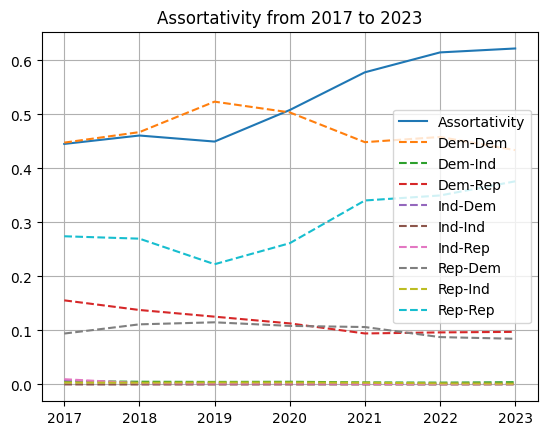

In [24]:
plt.plot([2017,2018,2019,2020,2021,2022,2023], ass_coef_list, label="Assortativity")

for normalized,label in zip(normalized_list, ["Dem-Dem","Dem-Ind","Dem-Rep","Ind-Dem","Ind-Ind","Ind-Rep","Rep-Dem","Rep-Ind","Rep-Rep"]):
    plt.plot([2017,2018,2019,2020,2021,2022,2023],normalized, label=label,linestyle='dashed')

plt.title("Assortativity from 2017 to 2023")
plt.grid()
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2916efa0-c445-43ca-8dcd-0a1bcdbbd016' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>